In [1]:
import numpy as np
import os
from tensorflow import keras
from keras_bert import get_base_dict, get_model, compile_model, gen_batch_inputs, get_custom_objects
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
np.random.seed(12345)

## Reconstructing the dictonary from training data

This step appears necessary so that the validation data and training data share the same UMID --> token mapping. This mapping can vary based on the order of when a sequence appears in the loop, hence need to use the training data to reconstruct it for consistency. Of course, we can always save a constructed dict and load it as well, based on needs.

In [6]:
base_path = '/pscratch/sd/a/andrish/hept'
input_dir = f'{base_path}/train_data' # The input directory for data

data = np.load(f'{input_dir}/inputs/train.npz', allow_pickle=True)
seq = data['seq']
true_pt = data['true_pt']
true_seq = []

for i in range(len(seq)):
    temp = []
    for j in range(len(seq[i])):
        temp.append(seq[i][j])
    true_seq.append(temp)
    
sentence_pairs2 = []
for i in range(0, len(true_seq)-1, 2):
    if true_pt[i] >= true_pt[i+1]:
        sentence_pairs2.append([true_seq[i], true_seq[i+1]])
    else:
        sentence_pairs2.append([true_seq[i+1], true_seq[i]])
    
# Build token dictionary
token_dict = get_base_dict()  # A dict that contains some special tokens
for pairs in sentence_pairs2:
    for token in pairs[0] + pairs[1]:
        if token not in token_dict:
            token_dict[token] = len(token_dict)
token_list = list(token_dict.keys())  # Used for selecting a random word
token_dict_inv = {v: k for k, v in token_dict.items()} # Get the inverse mapping from actual token to UMID

In [7]:
from process_data import TrackMLReader

## Reproduce umid_dict the same way as in process_data
data_input_dir = "/global/cfs/cdirs/m3443/data/trackml-kaggle/train_all"
detector_path = f'{base_path}/detectors.csv'
reader = TrackMLReader(data_input_dir, detector_path=detector_path)
detector = pd.read_csv(detector_path)

detector_umid = np.stack([detector.volume_id, detector.layer_id, detector.module_id], axis=1)
umid_dict = {}
index = 1
for i in detector_umid:
    umid_dict[tuple(i)] = index
    index += 1

## Inverting the umid_dict
umid_dict_inv = {v: k for k, v in umid_dict.items()}

total 8850 events in directory: /global/cfs/cdirs/m3443/data/trackml-kaggle/train_all
Loading detector...
Detector loaded.


## Loading test/validation data

In [8]:
input_dir = f'{base_path}/train_data' # The directory that store the validation data

data = np.load(f'{input_dir}/inputs/val.npz', allow_pickle=True)
seq0 = data['seq']
pt = data['true_pt']
ind = np.flip(np.argsort(pt.flatten()))

sort_all = False # If true, the entire data will be sorted in decreasing Pt order
sort_pairs = True # If true, each pair will be sorted in decreasing Pt order, but not necessarily the entire dataset

if sort_all:
    seq = seq0[ind]
else:
    seq = seq0

print('>>> Number of sequences:', len(seq))
true_seq = []
for i in range(len(seq)):
    temp = []
    for j in range(len(seq[i])):
        temp.append(seq[i][j])
    true_seq.append(temp)
    
sentence_pairs = []
if sort_pairs:
    for i in range(0, len(true_seq)-1, 2):
        if pt[i] >= pt[i+1]:
            sentence_pairs.append([true_seq[i], true_seq[i+1]])
        else:
            sentence_pairs.append([true_seq[i+1], true_seq[i]])
else:
    for i in range(0, len(true_seq)-1, 2):
        sentence_pairs.append([true_seq[i], true_seq[i+1]])

>>> Number of sequences: 509171


## Utils
[WARNING] A lot of util functions are here! For future development, consider place some/all of them into a .py file and load them when needed.

### Used for input loading

In [36]:
total_size = len(sentence_pairs)
def test_generator(batch_size=5000, seq_len=10, mask_id=None,
                     mask_first=True):
    """
    A generator to generate test inputs.
    
    Parameters
    ----------
    batch_size : int
        The batch size for inference
    seq_len : int
        The sequence length
    mask_id : str
        "first", "last", or anything else, if "first" then masking the first
        hit in the track, if "last" then masking the last, else then randomly
        mask one hit in the middle of the track
    mask_first : bool
        If true, mask one element in track A of input pair [A, B], else then
        mask one element in track B
        
    Returns
    -------
    A batch of inputs in tuples in order of
        * inputs: input token array
        * outputs: truth array
        * masked_seq_len: the length of the sequence masked
        * mask_position: the position of the mask
        * mlm_truth: truth token for the masked hit
    """
    i = 0
    while True:
        yield gen_batch_inputs(
                     sentence_pairs[i*batch_size:],
                     token_dict,
                     token_list,
                     batch_size=batch_size,
                     seq_len=seq_len,
                     #mask_rate=mask_rate, # Not needed since this is not training
                     #mask_mask_rate=0., 
                     #mask_random_rate=0.,
                     #swap_sentence_rate=0.,
                     #force_mask=True,
                     mask_id=mask_id,
                     mask_first=mask_first
        )
        if (i+1) * batch_size >= total_size:
            i = 0
        else:
            i += 1
            
def test_generator_multimask(batch_size=5000, seq_len=10, mask_n=2,
                     mask_first=True):
    """
    A generator to generate test inputs for masking multiple hits in the track.
    
    Parameters
    ----------
    batch_size : int
        The batch size for inference
    seq_len : int
        The sequence length
    mask_n : int
        Number of elements to mask in a sequence
    mask_first : bool
        If true, mask one element in track A of input pair [A, B], else then
        mask one element in track B
        
    Returns
    -------
    A batch of inputs in tuples in order of
        * inputs: input token array
        * outputs: truth array
        * masked_seq_len: the length of the sequence masked
        * mask_position: the position of the mask
        * mlm_truth: truth token for the masked hit
    """
    i = 0
    while True:
        yield gen_batch_inputs_multimask(
                     sentence_pairs[i*batch_size:],
                     token_dict,
                     token_list,
                     batch_size=batch_size,
                     seq_len=seq_len,
                     #mask_rate=mask_rate,  # Not needed since this is not training
                     #mask_mask_rate=0.,
                     #mask_random_rate=0.,
                     #swap_sentence_rate=0.,
                     #force_mask=True,
                     mask_n=mask_n,
                     mask_first=mask_first
        )
        if (i+1) * batch_size >= total_size:
            i = 0
        else:
            i += 1

In [11]:
def tokenize(test_seq):
    """
    Tokenize an input sequence into inputs needed for predictions.
    
    Parameters
    ----------
    test_seq : arr
        The input sequence, in the form of a tuple
        
    Returns
    -------
    test_input : arr
        Test input to feed into a model for prediction
    truth : arr
        The truth array
    mask_position : int or arr
        The index for the masked hit(s)
    mask_seq_len : int
        The sequence length of the masked array
    """
    [indices, seg, masks], [truth_seq, _], mask_seq_len, mask_position, truth = test_seq
    test_input = [indices, seg, masks]
    truth = list(truth) 
    return test_input, truth, mask_position, mask_seq_len # mask indices

In [12]:
def gen_batch_inputs(sentence_pairs,
                     token_dict,
                     token_list,
                     batch_size=5000,
                     seq_len=512,
                     mask_rate=0.15,
                     mask_id=None,
                     mask_first=True):
    """Generate a batch of inputs and outputs for testing.

    :param sentence_pairs: A list of pairs containing lists of tokens.
    :param token_dict: The dictionary containing special tokens.
    :param token_list: A list containing all tokens.
    :param seq_len: Length of the sequence.
    :param mask_rate: The rate of choosing a token for prediction.
    :param mask_mask_rate: The rate of replacing the token to `TOKEN_MASK`.
    :param mask_random_rate: The rate of replacing the token to a random word.
    :param swap_sentence_rate: The rate of swapping the second sentences.
    :param force_mask: At least one position will be masked.
    :return: All the inputs and outputs.
    """
    TOKEN_PAD = ''  # Token for padding
    TOKEN_UNK = '[UNK]'  # Token for unknown words
    TOKEN_CLS = '[CLS]'  # Token for classification
    TOKEN_SEP = '[SEP]'  # Token for separation
    TOKEN_MASK = '[MASK]'  # Token for masking
    batch_size = min(batch_size, len(sentence_pairs))
    base_dict = get_base_dict()
    unknown_index = token_dict[TOKEN_UNK]
    nsp_outputs = np.zeros((batch_size,))
    
    # Generate MLM
    token_inputs, segment_inputs, masked_inputs = [], [], []
    mlm_outputs = []
    masked_seq_len = []
    mask_position = []
    mlm_truth = []
    for i in range(batch_size):
        first, second = sentence_pairs[i]
        segment_inputs.append(([0] * (len(first) + 2) + [1] * (seq_len - (len(first) + 2)))[:seq_len])
        tokens = [TOKEN_CLS] + first + [TOKEN_SEP] + second + [TOKEN_SEP]
        tokens = tokens[:seq_len]
        tokens += [TOKEN_PAD] * (seq_len - len(tokens))
        token_input, masked_input, mlm_output = [], [], []

        for token in tokens:
            mlm_output.append(token_dict.get(token, unknown_index))
            masked_input.append(0)
            token_input.append(token_dict.get(token, unknown_index))
            
        if mask_first:
            start, end, length = 1, len(first), len(first)
        else:
            start, end, length = len(first)+2, len(first)+len(second)+1, len(second)
            
        if mask_id == 'first':
            mid = start
        elif mask_id == 'last':
            mid = end
        else:
            mid = np.random.randint(start+1, end)
        
        masked_input[mid] = 1
        token_input[mid] = token_dict[TOKEN_MASK] # NOTE: Changing the test input to the [MASK] token, effect unclear
        mask_position.append(mid)
        masked_seq_len.append(length)
        token_inputs.append(token_input)
        masked_inputs.append(masked_input)
        mlm_outputs.append(mlm_output)
        mlm_truth.append(mlm_output[mid])
    inputs = [np.asarray(x) for x in [token_inputs, segment_inputs, masked_inputs]]
    outputs = [np.asarray(np.expand_dims(x, axis=-1)) for x in [mlm_outputs, nsp_outputs]]
    
    return inputs, outputs, masked_seq_len, mask_position, mlm_truth

In [13]:
def gen_batch_inputs_multimask(sentence_pairs,
                     token_dict,
                     token_list,
                     batch_size=5000,
                     seq_len=512,
                     mask_rate=0.15,
                     mask_n=2,
                     mask_first=True):
    """Generate a batch of inputs and outputs for testing.
    Multiple masks can be applied based on mask_n.

    :param sentence_pairs: A list of pairs containing lists of tokens.
    :param token_dict: The dictionary containing special tokens.
    :param token_list: A list containing all tokens.
    :param seq_len: Length of the sequence.
    :param mask_rate: The rate of choosing a token for prediction.
    :param mask_mask_rate: The rate of replacing the token to `TOKEN_MASK`.
    :param mask_random_rate: The rate of replacing the token to a random word.
    :param swap_sentence_rate: The rate of swapping the second sentences.
    :param force_mask: At least one position will be masked.
    :return: All the inputs and outputs.
    """
    TOKEN_PAD = ''  # Token for padding
    TOKEN_UNK = '[UNK]'  # Token for unknown words
    TOKEN_CLS = '[CLS]'  # Token for classification
    TOKEN_SEP = '[SEP]'  # Token for separation
    TOKEN_MASK = '[MASK]'  # Token for masking
    batch_size = min(batch_size, len(sentence_pairs))
    base_dict = get_base_dict()
    unknown_index = token_dict[TOKEN_UNK]
    nsp_outputs = np.zeros((batch_size,))
    
    # Generate MLM
    token_inputs, segment_inputs, masked_inputs = [], [], []
    mlm_outputs = []
    masked_seq_len = []
    mask_position = []
    mlm_truth = []
    for i in range(batch_size):
        first, second = sentence_pairs[i]
        segment_inputs.append(([0] * (len(first) + 2) + [1] * (seq_len - (len(first) + 2)))[:seq_len])
        tokens = [TOKEN_CLS] + first + [TOKEN_SEP] + second + [TOKEN_SEP]
        tokens = tokens[:seq_len]
        tokens += [TOKEN_PAD] * (seq_len - len(tokens))
        token_input, masked_input, mlm_output = [], [], []

        for token in tokens:
            mlm_output.append(token_dict.get(token, unknown_index))
            masked_input.append(0)
            token_input.append(token_dict.get(token, unknown_index))
            
        if mask_first:
            start, end, length = 1, len(first), len(first)
        else:
            start, end, length = len(first)+2, len(first)+len(second)+1, len(second)
            
        
        mids = np.random.randint(start, end, mask_n)
        mlm_truth_temp = []
        for mid in mids:
            token_input[mid] = token_dict[TOKEN_MASK] # NOTE: Changing the test input to the [MASK] token, effect unclear
            masked_input[mid] = 1
            mask_position.append(mid)
            mlm_truth_temp.append(mlm_output[mid])
        masked_seq_len.append(length)
        token_inputs.append(token_input)
        masked_inputs.append(masked_input)
        mlm_outputs.append(mlm_output)
        mlm_truth.append(mlm_truth_temp)
    inputs = [np.asarray(x) for x in [token_inputs, segment_inputs, masked_inputs]]
    outputs = [np.asarray(np.expand_dims(x, axis=-1)) for x in [mlm_outputs, nsp_outputs]]

    return inputs, outputs, masked_seq_len, mask_position, mlm_truth

### Used for post-processing data

In [29]:
def dist(t, p):
    """
    Calculating the Euclidean distance between the center of the predicted detector element
    and the true detector element.
    
    Parameters
    ----------
    t : int
        The truth index for the detector module
    p : int
        The predicted index for the detector module
    
    Returns
    -------
    The distance between t and p
    """
    r = np.array([detector.loc[t]['cx'], detector.loc[t]['cy'],detector.loc[t]['cz']])
    rp = np.array([detector.loc[p]['cx'], detector.loc[p]['cy'],detector.loc[p]['cz']])
    return np.linalg.norm(r-rp)

def locate_mod(t):
    """
    Locate a module based on the index.
    
    Parameters
    ----------
    t : int
        UMID of the module
    
    Returns
    -------
    r, z : float, float
        The r, z coordinate of the detector module
    """
    V, L, M = umid_dict_inv[t]
    row = detector.loc[detector.volume_id==V].loc[detector.layer_id==L].loc[detector.module_id==M]
    r = np.sqrt(row['cx']**2 + row['cy']**2)
    z = row['cz']
    return float(r), float(z)

def get_track_len(test_trk, n_mask=1):
    """
    Get the length of the test_trk
    """
    seq = test_trk[0][0]
    index = 0
    j = 0
    for i in seq:
        if i == 3:
            index = j
            break
        j += 1
    return [j-1]*n_mask

def calc_acc(D):
    """
    Calculating the accuracy of prediction, given their predicted distance D.
    Returns the accuracy of D = 0 and D < 100
    """
    acc_0 = len([i for i in D if i == 0]) / len(D)
    acc_100 = len([i for i in D if i <= 100]) / len(D)
    return acc_0, acc_100

### Plotting

In [15]:
def plot_D(D, ax, right_bound=1e4):
    """
    Plot the distribution (pdf and cdf) of distances in histogram.
    
    Parameters
    ----------
    D : arr
        Distances calculated
    ax : plt.axes
        An axis to plot the figure on, can be 
        initialized in fig, ax = plt.subplots()
    right_bound : float
        The upper bound for the x axis for better visualization
    """
    weights = np.ones_like(D) / len(D)
    rang = (min(D), max(D))
    bin_wid = 10
    rang_adj = (-10, min(max(D)+50, right_bound))
    nbins = int(rang_adj[1] - rang_adj[0]) // bin_wid + 1
    
    count, bins_count, _ = ax[0].hist(D, bins=nbins, range=rang_adj, weights=weights, align='mid')#, histtype='step', lw=2)
    cdf = np.cumsum(count)
    ax[1].plot(bins_count[1:], cdf)
    ax[0].set_xlabel('Distance (mm)')
    ax[1].set_xlabel('Distance (mm)')
    ax[0].set_ylabel(f'Normalized Frequency / {bin_wid:.2f} mm')
    ax[0].set_title(f'Normalized Distribution, Accuracy: {calc_acc(D)[0] *100:.2f}%')
    ax[1].set_title(f'Cumulative Distribution')
    ax[0].grid()
    ax[1].grid()

In [16]:
def plot_D_maskPos(D_first, D_mid, D_last, ax):
    """
    Plot the distances vs the mask positions.
    
    Parameters
    ----------
    D_first : arr
        The distances for predictions on masked hits
        that the FIRST element in a sequence
    D_mid : arr
        The distances for predictions on masked hits
        that in the MIDDLE of a sequence
    D_last : arr
        The distances for predictions on masked hits
        that the LAST element in a sequence
    ax : plt.axes
        An axis to plot the figure on, can be 
        initialized in fig, ax = plt.subplots()
    """
    x = np.arange(3)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 1
    acc0, acc100 = [], []
    for i in [D_first, D_last, D_mid]:
        a, b = calc_acc(i)
        acc0.append(a)
        acc100.append(b)

    rec1 = ax.bar(x, acc0, width, alpha=0.6, label='D = 0 mm')
    ax.bar_label(rec1, padding=2, fmt='%.2f')
    rec2 = ax.bar(x+width * multiplier, acc100, width, alpha=0.6, label='D < 100 mm')
    ax.bar_label(rec2, padding=2, fmt='%.2f')

    names = ['First', 'Mid', 'Last']
    ax.set_xticks(x + width/2, names)
    ax.set_xlabel('Mask Position')
    ax.set_ylabel('Proportion of Tracks')
    ax.set_ylim(0, 1)
    ax.set_title('Influence of Mask Position')
    ax.grid()
    ax.legend()

In [41]:
def refractor(D, L):
    """
    Calculate the mean and standard deviation for the distances
    of each track length. For instance, suppose the tracks with length
    4 have validation distances [100, 200], and tracks with length 5
    have distances [100, 500], then a dict of {4: [100, 200], 5: [100, 500]}
    will be formed and mean and std will be calculated for each track length.
    The return will be ([150, 300], [std([100,200]), std([100, 500])])
    
    Parameters
    ----------
    D : arr
        Distances between predicted modules and truth modules
    L : arr
        The corresponding length of the tracks used for inference
    
    Returns
    -------
    mean : arr
        The mean of respective distances
    std : arr
        The std of respective distances
    """
    base = {}
    for i in range(min(L), max(L)+1):
        base[i] = []
    for d, l in zip(D, L):
        base[l].append(d)
    mean, std = [], []
    for i in base:
        m = np.mean(base[i])
        s = np.std(base[i])
        mean.append(m)
        std.append(s)
    return mean, std

def plot_D_len(D, trk_len, ax):
    """
    Plot the distance w.r.t. different length of the tracks.
    
    Parameters
    ----------
    D : arr
        The distances
    trk_len : arr
        The length of the respective tracks
    ax : plt.axes
        The axis to plot on
    """
    ax.plot(trk_len, D, '.', markersize=5, label='Data')
    x = list(range(min(trk_len), max(trk_len)+1))
    mean, std = refractor(D, trk_len)
    ax.errorbar(x, mean, yerr=std, fmt='o', ecolor='r', capsize=2, label='Mean distance')
    ax.set_xticks(x)
    ax.legend()
    ax.grid()
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Distance (mm)')
    ax.set_title('Influence of Sequence Length')
    
def refractor2(D, L):
    """
    Calculate the mean and standard deviation for the distances
    of each detector module. For instance, suppose the detector module
    4 has validation distances [100, 200], and detector module 5
    has distances [100, 500], then a dict of {4: [100, 200], 5: [100, 500]}
    will be formed and mean and std will be calculated for each track length.
    The return will be ([150, 300], [std([100,200]), std([100, 500])], [4,5], dict)
    
    Parameters
    ----------
    D : arr
        Distances between predicted modules and truth modules
    L : arr
        The corresponding UMID
    
    Returns
    -------
    mean : arr
        The mean of respective distances
    std : arr
        The std of respective distances
    UMID : arr
        The list of all UMID encountered in this function
    base : dict
        The dictionary {UMID: distances}
    """
    base = {}
    for l in L:
        if l not in base:
            base[l] = []
    for d, l in zip(D, L):
        base[l].append(d)
    mean, std = [], []
    for i in base:
        m = np.mean(base[i])
        s = np.std(base[i])
        mean.append(m)
        std.append(s)
    return mean, std, list(base.keys()), base
    
def plot_D_mod(D, mod, ax):
    """
    Plot the different distances w.r.t. different detector module.
    
    Parameters
    ----------
    D : arr
        The distances
    mod : arr
        An array of respective UMIDs
    ax : plt.axes
        The axis to plot on
    """
    mean, std, UMID, base = refractor2(D, mod)
    acc0, acc100 = [], []
    for i in base:
        a, b = calc_acc(base[i])
        acc0.append(a)
        acc100.append(b)
    x = np.array(UMID)  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 1

    rec1 = ax[0].bar(x, acc0, width, label='D = 0 mm') # Bar plot for accuracy vs UMID
    ax[0].legend()
    ax[0].grid()
    ax[0].set_xlabel('Unique Module ID')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Accuracy vs UMID')
    
    r, z = [], []
    for umid in UMID:
        r0, z0 = locate_mod(umid) # use the r-z plane
        r.append(r0)
        z.append(z0)
    im = ax[1].scatter(z, r, s=3, c=acc0)#, cmap='Reds') # scatter plot, color is accuracy
    ax[1].set_xlabel('z (mm)')
    ax[1].set_ylabel('r (mm)')
    plt.colorbar(im, ax=ax[1])
    plt.tight_layout()

### Make predictions

In [18]:
def pred(model, mid, mask_first, n_sample=3000, seq_len=10, batch_size=1):
    """
    Make predictions.
    
    Parameters
    ----------
    model : keras.Model
        The model loaded, used to perform the inference
    mid : int
        A specific mask index
    mask_first : bool
        If true, mask one element in track A of input pair [A, B], else then
        mask one element in track B
    n_sample : int
        Number of samples for inference
    seq_len : int
        Sequence length
    batch_size : int
        Batch size
    
    Returns
    -------
    D : arr
        The Euclidean distance between the center of the predicted detector element
        and the true detector element
    m_id : arr
        The array of indices for the masked hits
    trk_len : arr
        Length of the sequence that has one or more masks
    pred : arr
        The actual prediction, in UMIDs
    truth : arr
        The truth, in UMIDs
    """
        
    truth = []
    pred = []
    m_id = []
    trk_len = []
    test_seq = test_generator(batch_size=batch_size, seq_len=seq_len,
                              mask_id=mid, mask_first=mask_first)
    for i in trange(n_sample, desc='inference'):
        
        ## Loading input sequence in batches
        seq = next(test_seq)
        test_trk, t, mask_i, mask_seq_len = tokenize(seq)
        m_id += mask_i
        trk_len += mask_seq_len
        
        ## Doing inferences
        predicts = model.predict(test_trk)[0].argmax(axis=-1) # [MSK, NSP], [0] gives a multi-class classification score for all possible words, argmax gives the most likely word
                                                              # shape = (batch_size, seq_len, n_words) --> outputs a list of most likely words with shape (batch_size, len_seq)
        ind = list(zip(list(range(len(predicts))), mask_i)) # FIXME: This is currently in an ugly list form to ensure the indices are correct, need to 
                                                            # change when applied to larger datasets for faster inference.
        p = [predicts[tuple(i)] for i in ind]
        truth += t
        pred += p
    
    ## Mapping the tokens back to UMID and calculate distance
    truth, pred = [token_dict_inv[i] for i in truth], [token_dict_inv[i] for i in pred] #
    D = []
    for i in trange(len(truth), desc='calc dist'):
        if type(truth[i]) == str:
            continue
        D.append(dist(truth[i], pred[i]))
    
    return D, m_id, trk_len, pred, truth

In [19]:
def get_results(model_name, n_sample=3000, seq_len=10, 
                right_bound=1e4, batch_size=1, mode='split'):
    """
    A compiled function to get the results. Will plot the following:
        * distribution of distances (pdf and cdf)
        * accuracy vs mask position
        * distance vs sequence length
        * accuracy vs UMID
    
    Parameters
    ----------
    model_name : str
        The path for to the saved model for inference
    n_sample : int
        The number of batches to use
    seq_len : int
        The total length of the input pair
    right_bound : float
        The upper bound for the x axis for better visualization
    batch_size : int
        The batch size
    mode : str
        If "first_only", then only do inference on the first track in
        each input pair [A, B]; else then do inference on each track 
        in the pair separately
    
    Returns
    -------
    D : arr
        Distances, in a flat array
    D_all : arr
        Distances in ndarray, preserving the structure to identify the
        correspondance between masked index and the respective distances
    L : arr
        Length of each sequence in prediction
    P : arr
        The sequence of predicted UMIDs
    T : arr
        The sequence of truth UMIDs
    """
    
    ## Load model
    model = load_model(model_name, custom_objects=get_custom_objects())
    
    D, D_all, trk_len, predi = [], [], [], []
    D1, D2, L1, L2, P1, P2, T1, T2 = [], [], [], [], [], [], [], []
    D1_all, D2_all = [], []
    
    ## Do inference for masking the first, mid, and last hit of each track
    for mid in ['first', 'mid', 'last']:
        d1, m, l1, p1, t1 = pred(model, mid, True, n_sample, seq_len=seq_len, 
                                 batch_size=batch_size)
        
        D1 += d1
        L1 += l1
        P1 += p1
        T1 += t1
        D1_all.append(d1)
        
        if mode != 'first_only':
            d2, m, l2, p2, t2 = pred(model, mid, False, n_sample, seq_len=seq_len, 
                                     batch_size=batch_size)
            D2 += d2
            L2 += l2
            P2 += p2
            T2 += t2
            D2_all.append(d2)
    
    ## Make plots
    if mode != 'first_only':
        for D, D_all, trk_len in [(D1, D1_all, L1), (D2, D2_all, L2)]:
            fig, ax = plt.subplots(figsize=(8,8), ncols=2, nrows=2)
            plot_D(D, ax[0], right_bound=right_bound)
            plot_D_maskPos(*D_all, ax[1][0])
            plot_D_len(D, trk_len, ax[1][1])
            plt.tight_layout()
            plt.show()
        fig, ax = plt.subplots(figsize=(6*2,6*2), nrows=2, ncols=2)
        plot_D_mod(D1, T1, ax[0])
        ax[0][0].set_title('Accuracy vs UMID (Inference on First Track in the Pair)')
        plot_D_mod(D2, T2, ax[1])
        ax[1][0].set_title('Accuracy vs UMID (Inference on Second Track in the Pair)')
        plt.show()
        return (D1,D2), (D1_all,D2_all), (L1, L2), (P1,P2), (T1,T2)
    else:
        D = D1 + D2
        D_all = D1_all + D2_all
        trk_len = L1 + L2
        fig, ax = plt.subplots(figsize=(8,8), ncols=2, nrows=2)
        plot_D(D, ax[0], right_bound=right_bound)
        plot_D_maskPos(*D_all, ax[1][0])
        plot_D_len(D, trk_len, ax[1][1])
        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(6*2,6), ncols=2)
        plot_D_mod(D, T1+T2, ax)
    return D, D_all, trk_len, predi, T1+T2

In [20]:
def pred_multimask(model, n, mask_first, n_sample=3000, seq_len=10, batch_size=1):
    """
    Make prediction for the case when multiple hits are masked in a sequence. See
    the function **pred** for details. They only differ in this function has an input
    *n*, which denotes the number of hits to mask.
    """
    truth = []
    pred = []
    m_id = []
    trk_len = []
    test_seq = test_generator_multimask(batch_size=batch_size, seq_len=seq_len,
                              mask_n=n, mask_first=mask_first)
    
    for i in trange(n_sample, desc='inference'):
        seq = next(test_seq)
        test_trk, t, mask_i, mask_seq_len = tokenize(seq)#, next(truth_seq))
    
        m_id += mask_i
        trk_len += mask_seq_len
        
        predicts = model.predict(test_trk)[0].argmax(axis=-1)#.tolist() # [MSK, NSP], [0] gives a multi-class classification score for all possible words, argmax gives the most likely word
                                                                        # shape = (batch_size, seq_len, n_words) --> outputs a list of most likely words with shape (batch_size, len_seq)
        ind1 = np.concatenate([[i]*n for i in range(len(predicts))], axis=0)
        ind = list(zip(ind1, mask_i))
        p = [predicts[tuple(i)] for i in ind]
        truth += t
        pred += p
    truth = np.array(truth).flatten()
    truth, pred = [token_dict_inv[i] for i in truth], [token_dict_inv[i] for i in pred]
    
    D = []
    for i in trange(len(truth), desc='calc dist'):
        if type(truth[i]) == str:
            continue
        D.append(dist(truth[i], pred[i]))

    return D, m_id, trk_len, pred, truth

def get_results_multimask(model_name, n=1, n_sample=3000, seq_len=10,  
                right_bound=1e4, batch_size=1, mode='split', plot=False):
    """
    A compiled function to get the results when multiple hits are masked.
    See **get_results** for more details. They only differ in that this
    function takes in an argument *n* denoting the number of hits to mask.
    Due to the multiple masks in a sequence, the only plots that can be
    made reasonably is the distribution of predicted distances.
    """
    model = load_model(model_name, custom_objects=get_custom_objects())
    
    
    D, D_all, trk_len, predi = [], [], [], []
    D1, D2, L1, L2, P1, P2, T1, T2 = [], [], [], [], [], [], [], []
    D1_all, D2_all = [], []
    
    
    d1, m, l1, p1, t1 = pred_multimask(model, n, True, n_sample, seq_len=seq_len, 
                             batch_size=batch_size)

    D1 += d1
    L1 += l1
    P1 += p1
    T1 += t1
    D1_all.append(d1)


    if mode != 'first_only':
        d2, m, l2, p2, t2 = pred_multimask(model, n, False, n_sample, seq_len=seq_len, 
                                 batch_size=batch_size)
        D2 += d2
        L2 += l2
        P2 += p2
        T2 += t2
        D2_all.append(d2)
    
    if mode != 'first_only':
        if plot:
            for D, D_all, trk_len in [(D1, D1_all, L1), (D2, D2_all, L2)]:
                fig, ax = plt.subplots(figsize=(8,4), ncols=2)
                plot_D(D, ax, right_bound=right_bound)
                plt.tight_layout()
                plt.show()
        fig, ax = plt.subplots(figsize=(6*2,6*2), nrows=2, ncols=2)
        plot_D_mod(D1, T1, ax[0])
        ax[0][0].set_title('Accuracy vs UMID (Inference on First Track in the Pair)')
        plot_D_mod(D2, T2, ax[1])
        ax[1][0].set_title('Accuracy vs UMID (Inference on Second Track in the Pair)')
        plt.show()
        
        return (D1,D2), (D1_all,D2_all), (L1, L2), (P1,P2), (T1,T2)
    else:
        D = D1 + D2
        D_all = D1_all + D2_all
        trk_len = L1 + L2
        
    return D, D_all, trk_len, predi, T1+T2

## Making some plots on dataset

In [21]:
R, Z, X, Y = [], [], [], []
j = 0
for i in detector.index:
    row = detector.loc[i]
    r = np.sqrt(row['cx']**2 + row['cy']**2)
    x = row['cx']
    y = row['cy']
    z = row['cz']
    R.append(r)
    Z.append(z)
    X.append(x)
    Y.append(y)

Text(0.5, 0, 'z (mm)')

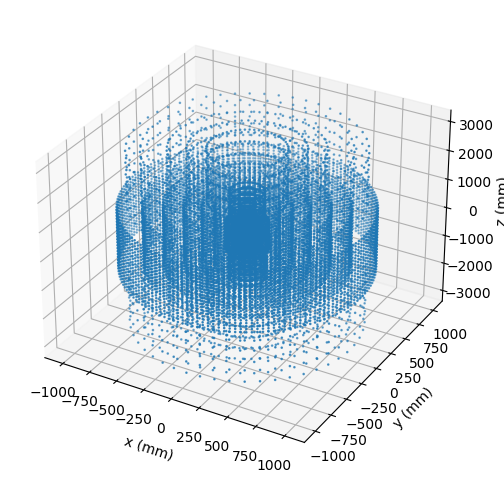

In [22]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(X, Y, Z, marker='.', s=3)
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

In [32]:
R = []
Z = []
for m in token_list[5:]:
    r, z = locate_mod(m)
    R.append(r)
    Z.append(z)

In [33]:
all_m = []
for r, z in zip(R, Z):
    if (r, z) in all_m:
        #print("bad")
        pass
    else:
        all_m.append((r, z))

Text(0, 0.5, 'r (mm)')

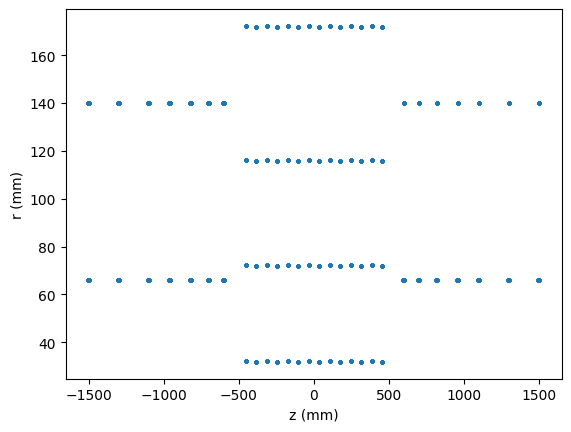

In [34]:
plt.plot(Z, R, 'o', markersize=2)
plt.xlabel('z (mm)')
plt.ylabel('r (mm)')

## Inference results

calc dist: 100%|██████████| 10000/10000 [00:06<00:00, 1499.56it/s]


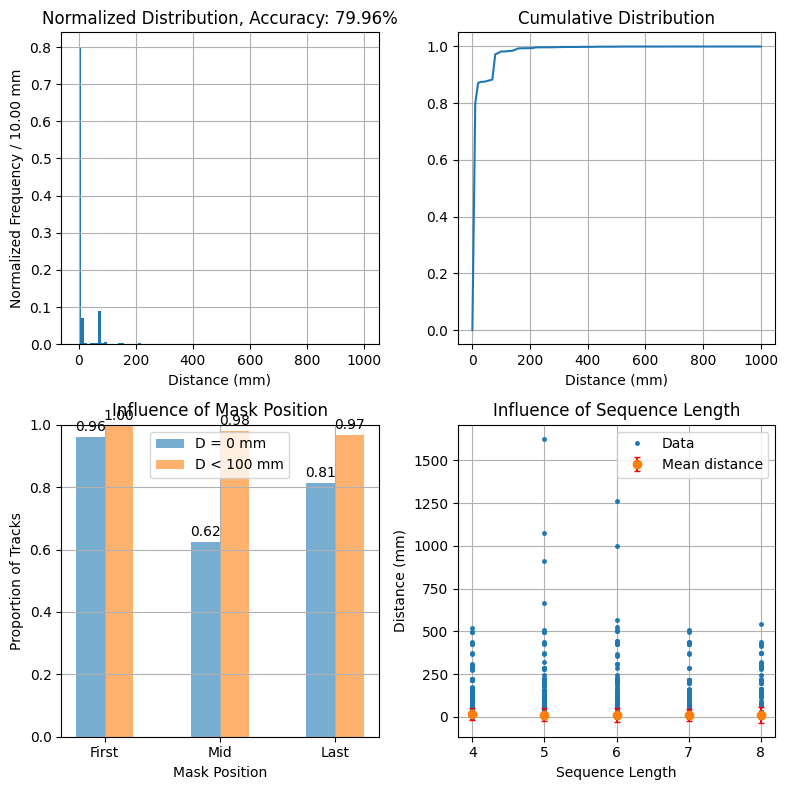

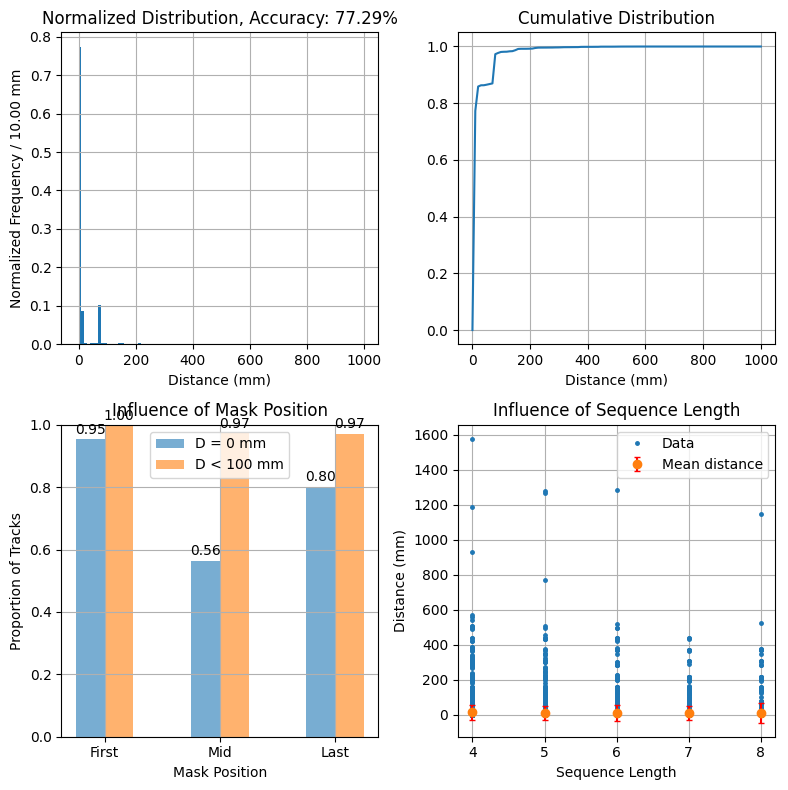

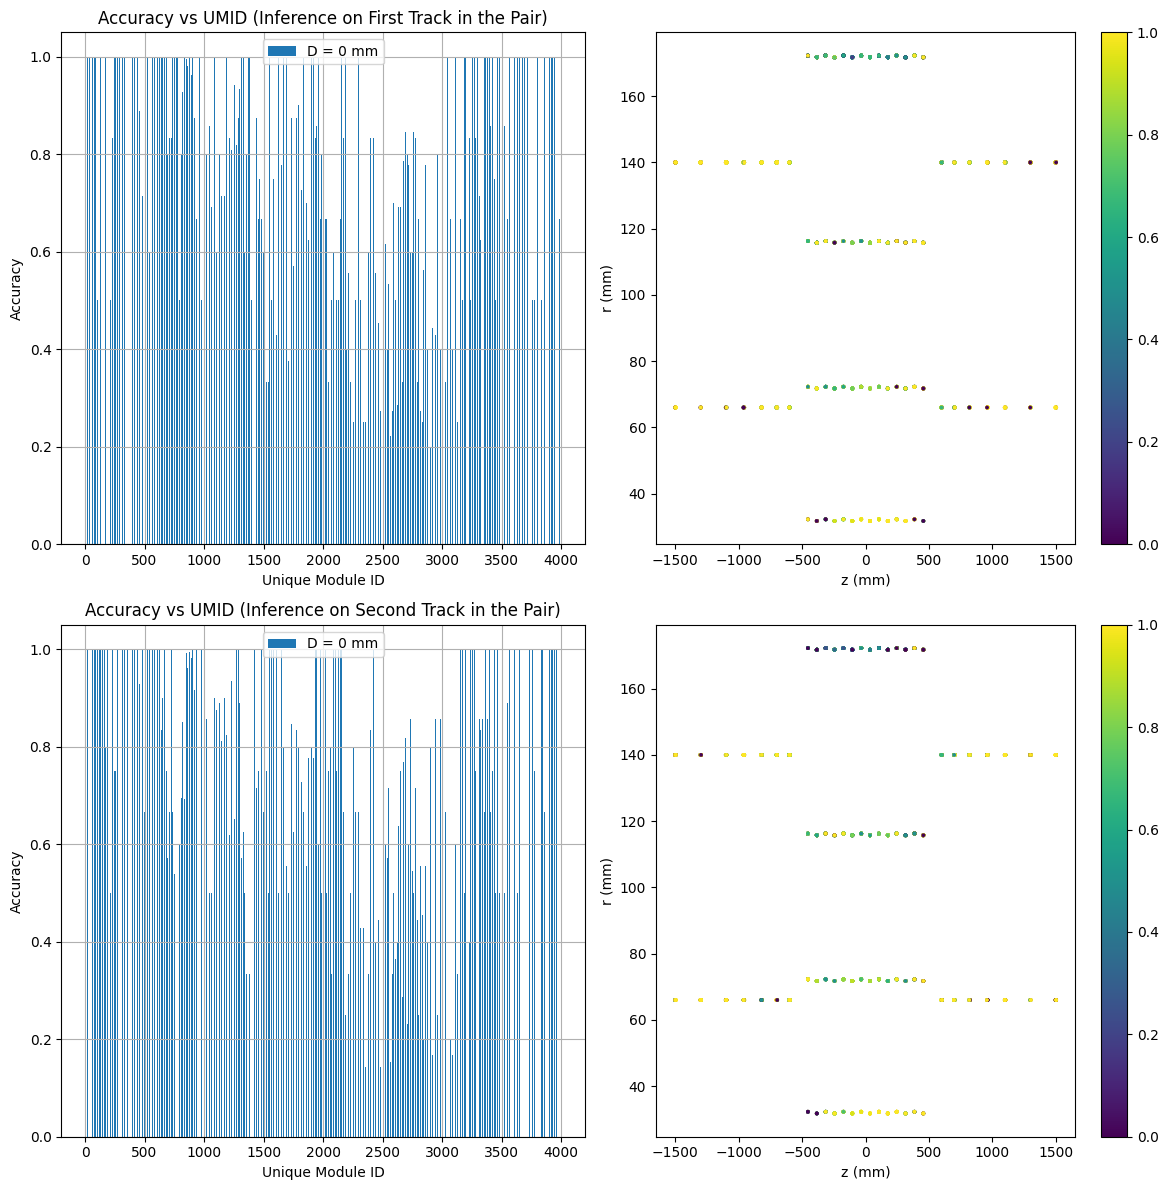

In [43]:
D, m_id, trk_len, predi, truth = get_results(f'{base_path}/test_model14', n_sample=2, 
                                             seq_len=19, right_bound=1000, batch_size=5000)

calc dist: 100%|██████████| 10000/10000 [00:04<00:00, 2046.67it/s]


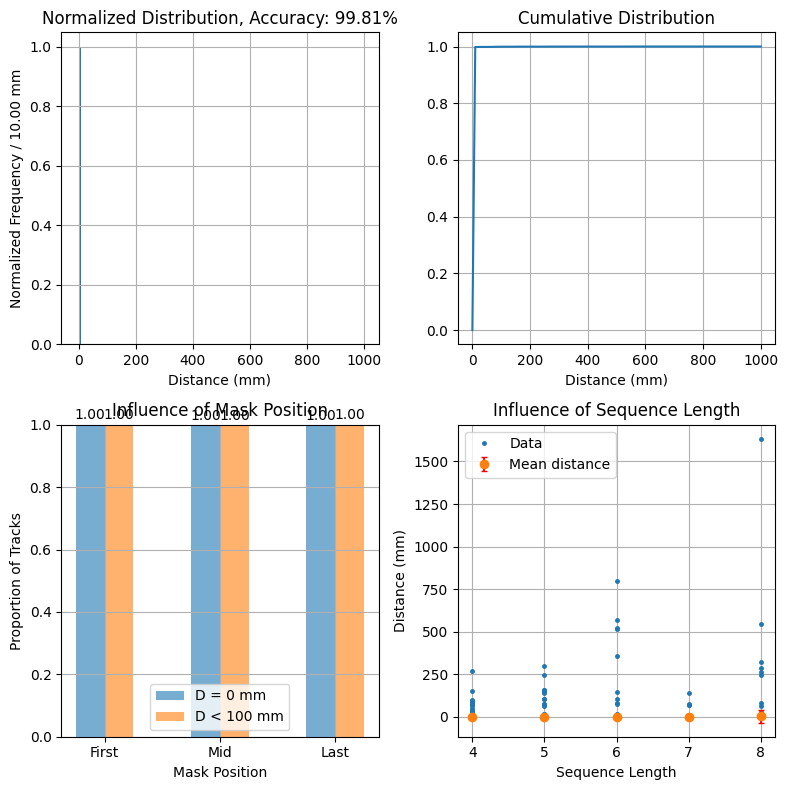

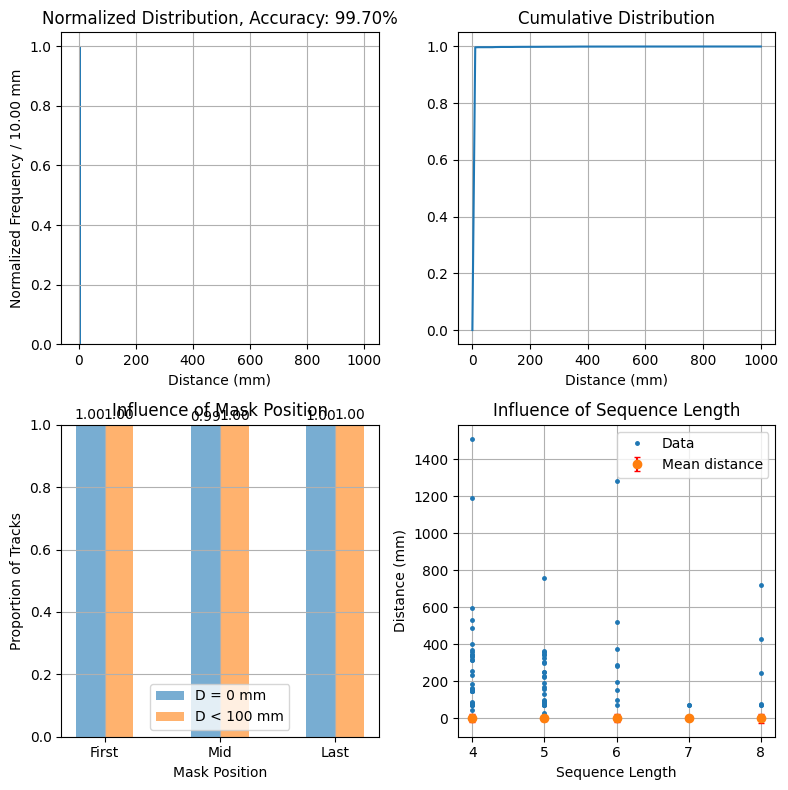

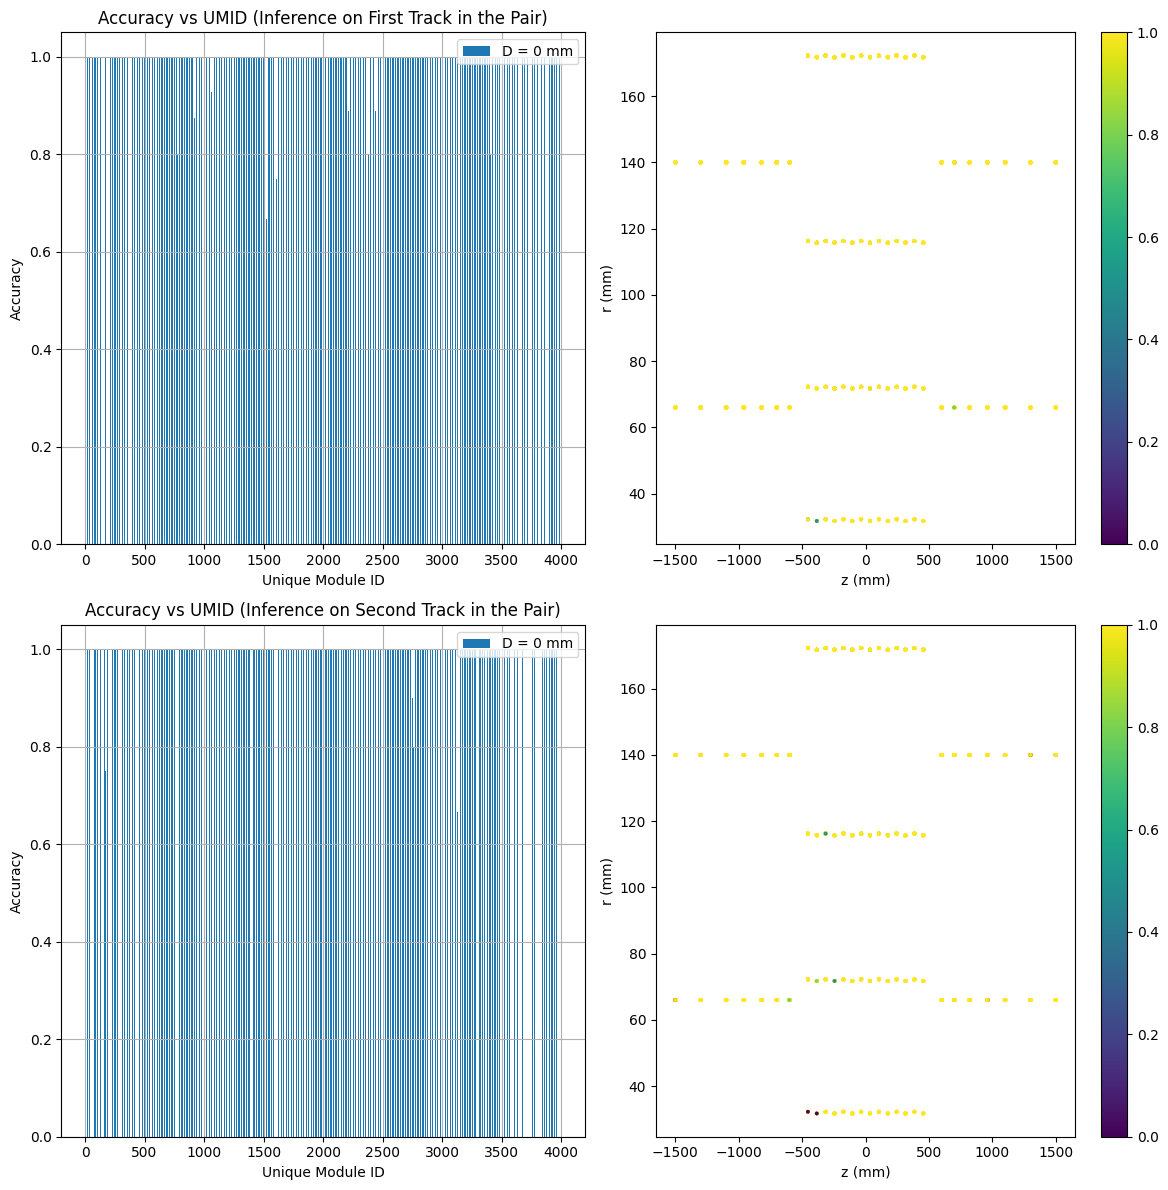

In [110]:
D, m_id, trk_len, predi, truth = get_results('test_model13', n_sample=2, 
                                             seq_len=19, right_bound=1000, batch_size=5000)

calc dist: 100%|██████████| 10000/10000 [00:05<00:00, 1939.05it/s]


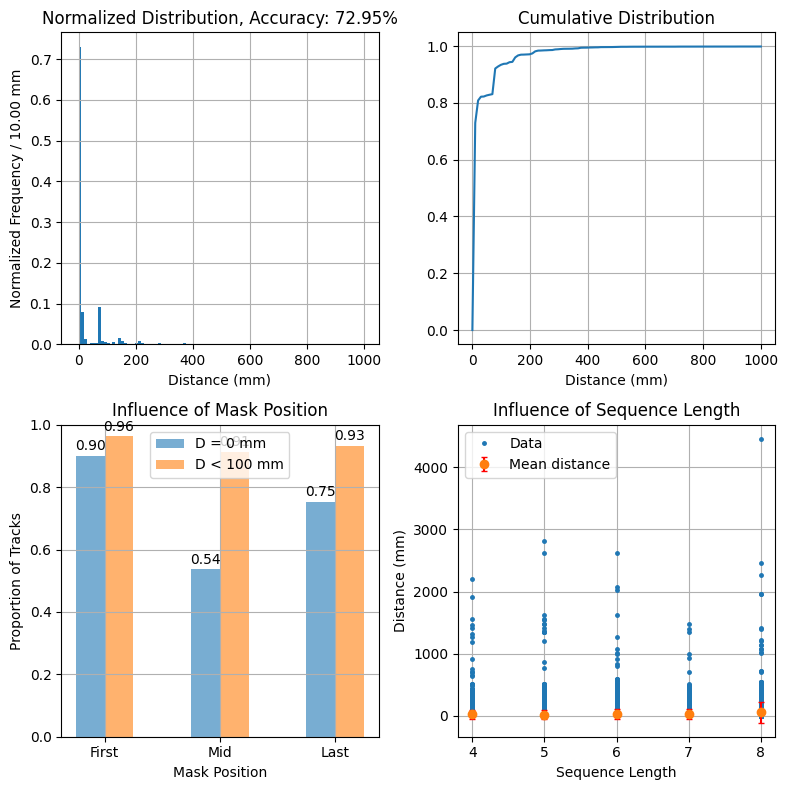

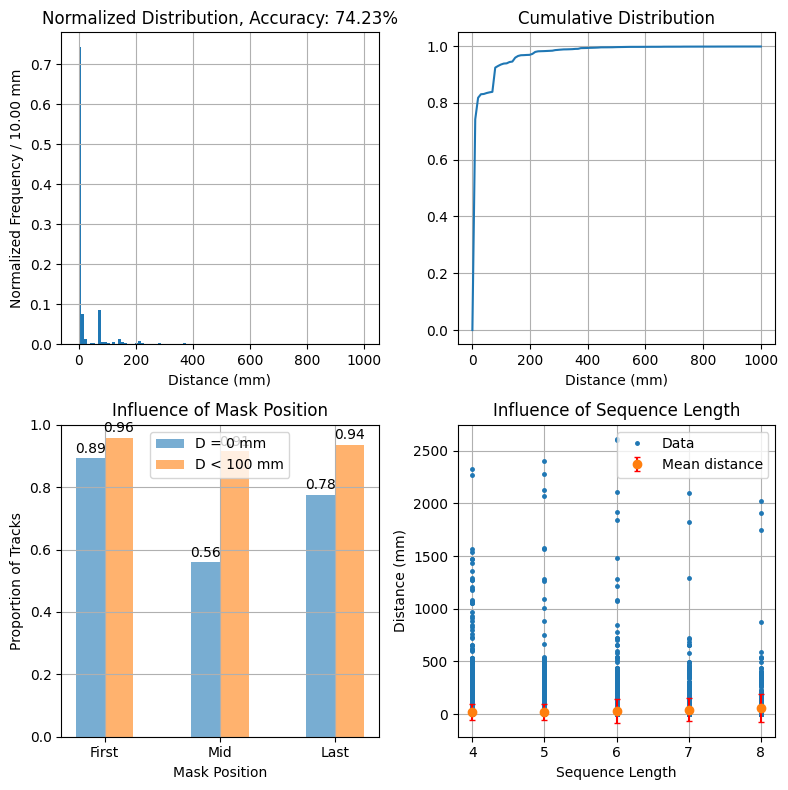

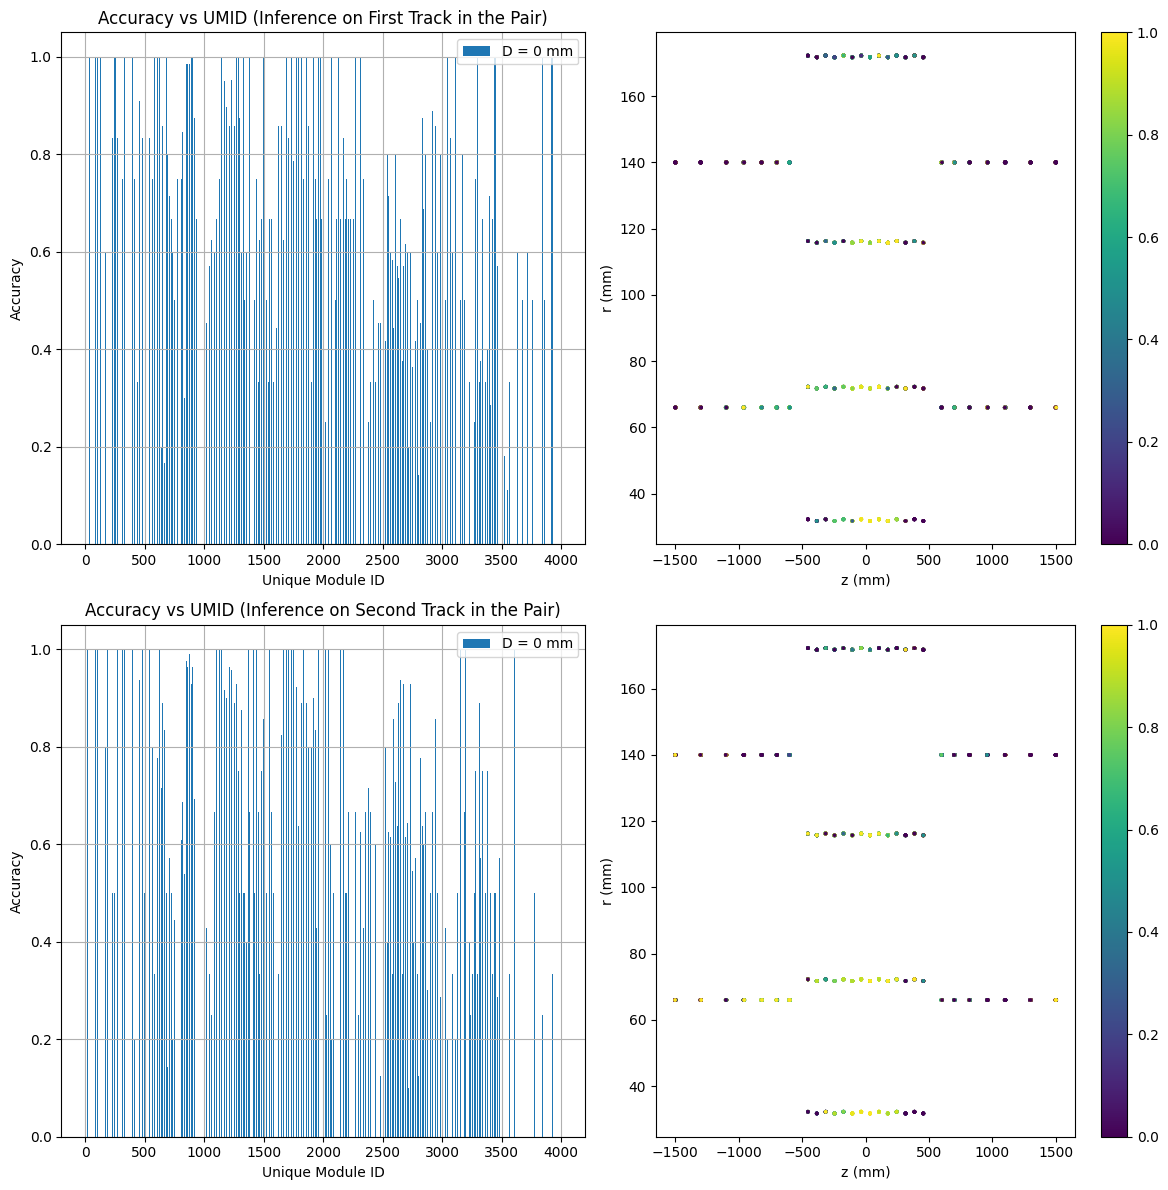

In [114]:
D, m_id, trk_len, predi, truth = get_results('test_model12', n_sample=2, 
                                             seq_len=19, right_bound=1000, batch_size=5000)

calc dist: 100%|██████████| 10000/10000 [00:04<00:00, 2029.45it/s]


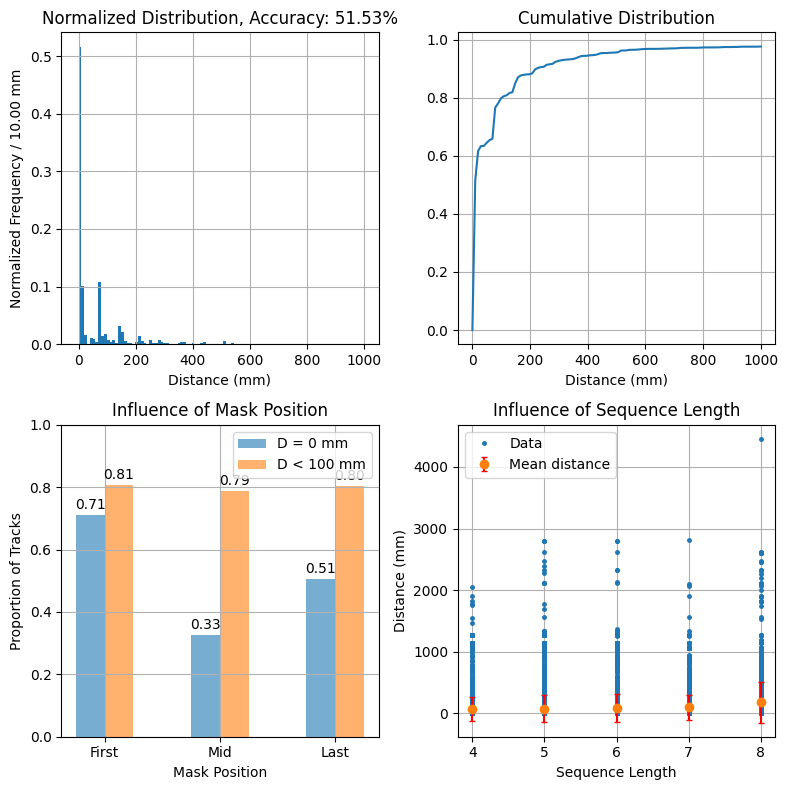

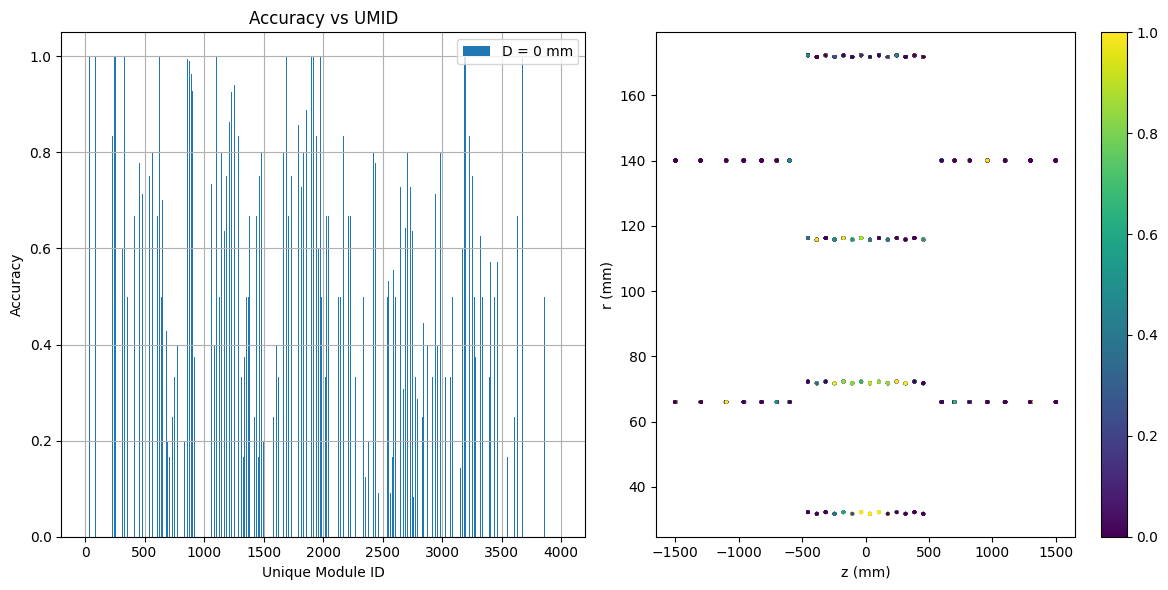

In [113]:
D, m_id, trk_len, predi, truth = get_results('test_model9', n_sample=2, mode='first_only',
                                             seq_len=10, right_bound=1000, batch_size=5000)

calc dist: 100%|██████████| 10000/10000 [00:04<00:00, 2058.27it/s]


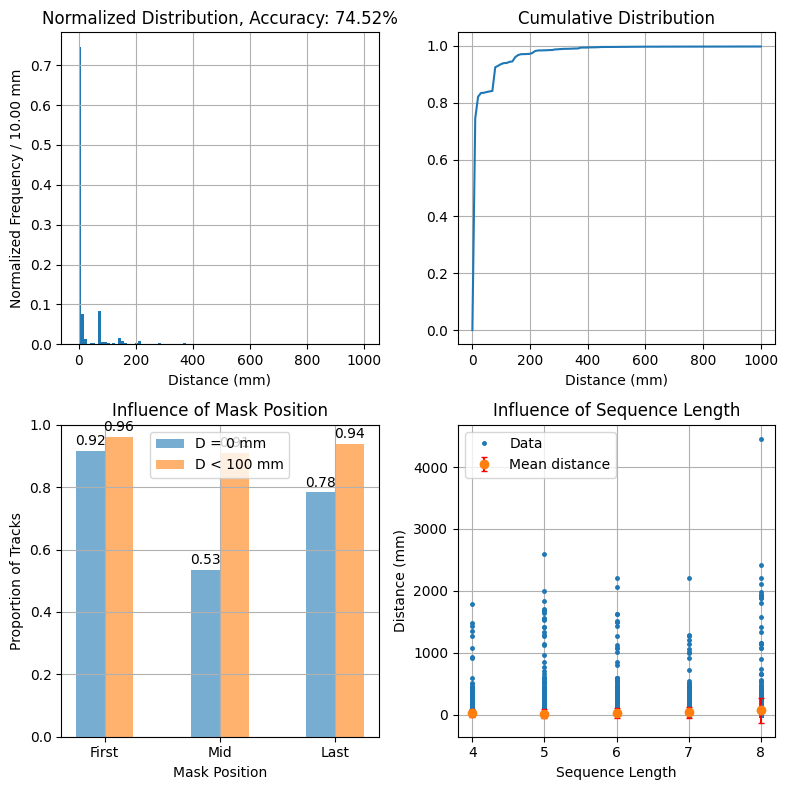

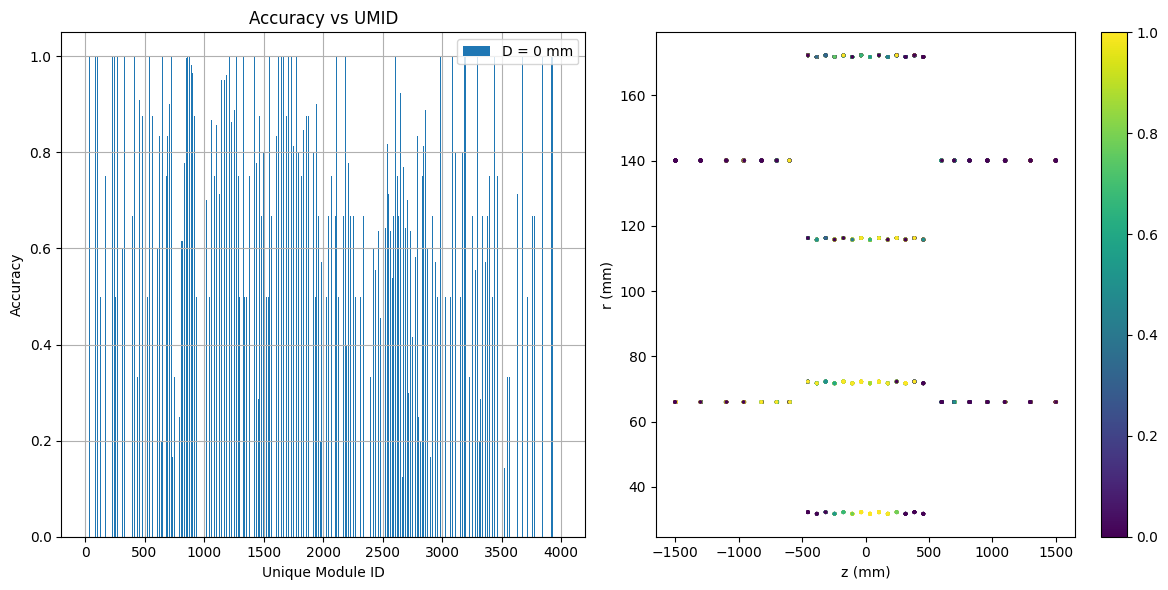

In [111]:
D, m_id, trk_len, predi, truth = get_results('test_model10', n_sample=2, mode='first_only',
                                             seq_len=10, right_bound=1000, batch_size=5000)

calc dist: 100%|██████████| 10000/10000 [00:04<00:00, 2025.60it/s]


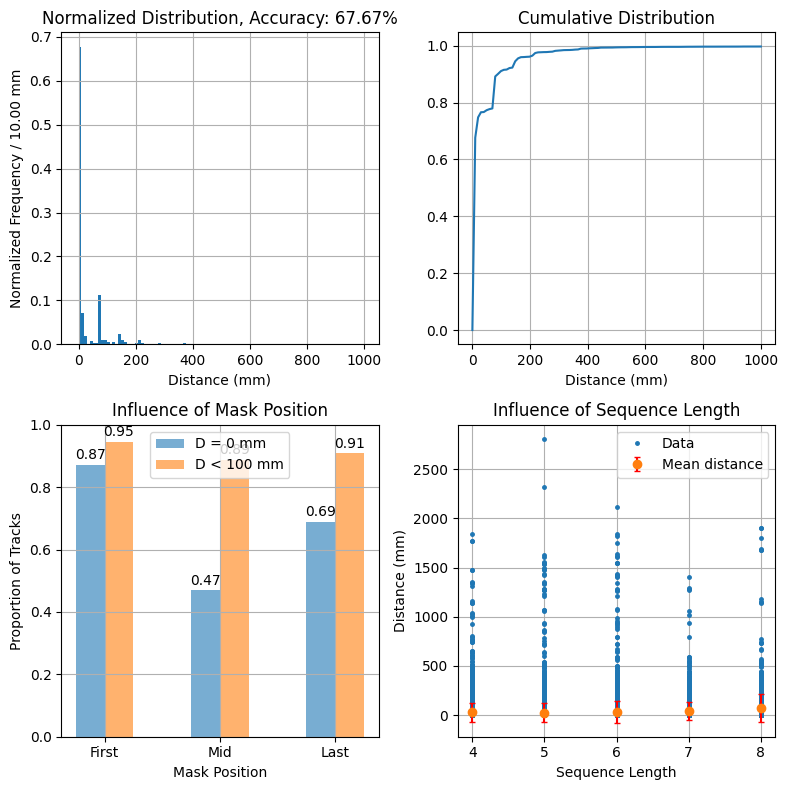

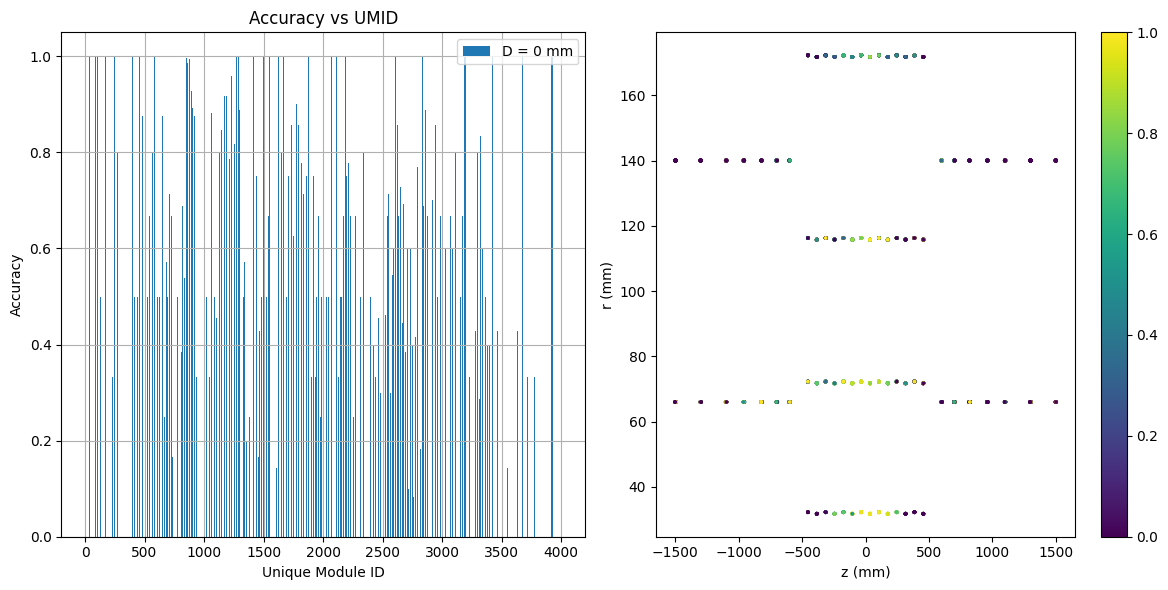

In [112]:
D, m_id, trk_len, predi, truth = get_results('test_model11', n_sample=2, mode='first_only',
                                             seq_len=10, right_bound=1000, batch_size=5000)

In [27]:
model = load_model('test_model10', custom_objects=get_custom_objects()) # A demo that a model can be load in this way using model path
                                                                        # custum_objects is needed to avoid loading errors
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 10)]         0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 10, 25), (40 100225      Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 10, 25)       50          Input-Segment[0][0]              
______________________________________________________________________________________________